In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import graphviz
import torch_geometric
from torch_geometric.data import Dataset, Data, InMemoryDataset
from torch_geometric.utils import scatter

import os.path as osp
import ast
from sklearn.preprocessing import MinMaxScaler
import torchmetrics
import sys
import os
from datetime import datetime
sys.path.append(os.path.abspath("src"))
sys.path.append(os.path.abspath("src/torch"))
from salb_dataset import *
from gnns import *
from SALBP_solve import *
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'torch_scatter'

In [2]:



my_dataset = SALBDataset(root='pytorch_datasets/n_50',edge_data_csv ="n_50_all.csv",  raw_data_folder ="pytorch_datasets/n_50/raw/")
print(len(my_dataset))
my_dataset =  [data for data in my_dataset if data.graph_class]
print(len(my_dataset))

19014
2985


In [3]:
#! rm -r pytorch_datasets/n_50/processed/

In [4]:
len(my_dataset)

2985

In [5]:
print(my_dataset[0].x)

tensor([[0.2880],
        [0.3090],
        [0.2740],
        [0.2590],
        [0.2760],
        [0.1930],
        [0.3230],
        [0.2540],
        [0.3020],
        [0.2280],
        [0.2790],
        [0.2930],
        [0.2870],
        [0.2190],
        [0.2030],
        [0.3290],
        [0.2270],
        [0.2090],
        [0.2570],
        [0.3470],
        [0.1990],
        [0.1740],
        [0.3080],
        [0.1790],
        [0.2470],
        [0.3040],
        [0.2910],
        [0.1780],
        [0.3320],
        [0.1160],
        [0.2300],
        [0.3420],
        [0.1620],
        [0.3190],
        [0.2050],
        [0.2830],
        [0.2220],
        [0.2900],
        [0.2300],
        [0.3470],
        [0.3250],
        [0.2250],
        [0.2900],
        [0.2080],
        [0.1850],
        [0.3340],
        [0.2090],
        [0.2300],
        [0.3280],
        [0.3340]])


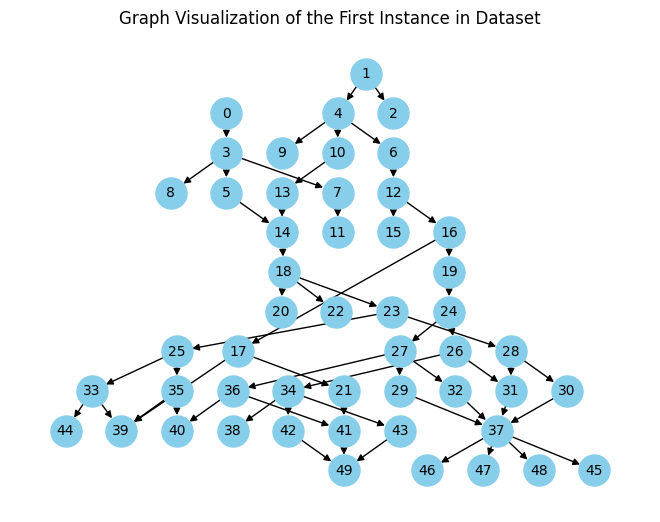

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the first graph in my_dataset is at index 0
data = my_dataset[0]
def plot_pytorch_graph(data):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    graph = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    #adds nodes
    for j in range(data.x.shape[1]):
        graph.add_node(j)
    #adds edges
    for i in range(edge_index.shape[1]):
        graph.add_edge(edge_index[0, i], edge_index[1, i])

    pos = nx.nx_pydot.graphviz_layout(graph, prog = "dot")

    # Draw the graph, changes graph to graphviz and uses
    nx.draw(graph, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", pos=pos)

    plt.title("Graph Visualization of the First Instance in Dataset")
    plt.show()
plot_pytorch_graph(data)

In [7]:
# Get global statistics across all graphs
# def get_edge_label_stats(dataset):
#     all_labels = []
#     for data in dataset:
#         all_labels+=data.edge_classes
    
#     torch_labels = torch.tensor(all_labels, dtype=torch.bool)
#     counts = torch.bincount(torch_labels.int())
#     return counts

# # Calculate class weights
# class_counts= get_edge_label_stats(my_dataset)
# total_edges = class_counts.sum()
# class_weights = total_edges / (2 * class_counts)
# class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)

# Count total positive and negative edges across all graphs
# def get_pos_weight(data_list):
#     num_pos = sum(data.edge_classes.sum().item() for data in data_list)
#     num_neg = sum(len(data.edge_classes) - data.edge_classes.sum().item() for data in data_list)
    
#     # Compute pos_weight for BCEWithLogitsLoss
#     pos_weight = torch.tensor([num_neg / num_pos])  # Shape: (1,)
#     print(f"num pos {num_pos} num neg {num_neg} pos weight {pos_weight}")
#     percent_pos = num_pos/(num_pos + num_neg)
#     percent_neg = num_neg/(num_pos + num_neg)
#     print(f"Percent positive {percent_pos} percent negative {percent_neg}")
#     return pos_weight
pos_weight = get_pos_weight(my_dataset)
#n_neg

num pos 25950 num neg 226779 pos weight tensor([8.7391])
Percent positive 0.10267915435110335 percent negative 0.8973208456488967


In [8]:
from torch_geometric.loader import DataLoader


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)


# Hyperparameters
in_channels = 1 # Assuming a single feature per node.
hidden_channels = 64
out_channels = 1 # Number of classes for your classification task.
learning_rate = 0.001
epochs = 10000
batch_size = 256#TODO: Make it work for larger batch sizes
#splits the data into train and test
input_dataset = my_dataset.copy()
train_dataset, test_dataset = random_split(input_dataset, [int(len(input_dataset)*0.8), len(input_dataset) - int(len(input_dataset)*0.8)])
# train_dataset = [input_dataset[3]]
# test_dataset = [input_dataset[3]]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, n_workers=4 )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, n_workers=4)

accuracy = torchmetrics.Accuracy(task="binary").to(device)
precision = torchmetrics.Precision(task="binary").to(device)
recall = torchmetrics.Recall(task="binary").to(device)
f1_score = torchmetrics.F1Score(task="binary").to(device)


# Get today's date as a string
today_str = datetime.today().strftime('%Y-%m-%d')

# Use it in a filename
filename = f"training_log_{today_str}"
writer = SummaryWriter(f"runs/{filename}")

model = EdgeClassifier_GAT(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#loss_fn = torch.nn.BCEWithLogitsLoss()

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    # total_correct = 0
    # total = 0
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out.T, data.edge_classes.unsqueeze(dim=0).float())
        # probs = torch.sigmoid(out)
        # preds = (probs > 0.5).int().squeeze(1)
        # total_correct += (preds == data.edge_classes)
        # total += len(preds)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    
      
    writer.add_scalar('Loss/train', total_loss, epoch)
    # acc = toal_correct/total
    #writer.add_scalar('Accuracy/train', acc, epoch)
    # writer.add_scalar('Recall/train', rec, epoch)
    # writer.add_scalar('Precision/train', prec, epoch)

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')
    if epoch % 10 == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, 'checkpoint.pth')
        # Evaluation
        model.eval()
        #  Testing loop
        with torch.no_grad():
          total_loss = 0
          for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            loss = loss_fn(out.T, data.edge_classes.unsqueeze(dim=0).float())
            probs = torch.sigmoid(out)
            print()
            # Set a threshold to convert probabilities to binary predictions
            threshold = 0.5
            targets = data.edge_classes
            preds = (probs > 0.5).int().squeeze(1)
            acc = accuracy(preds, targets)
            prec = precision(preds, targets)
            rec = recall(preds, targets)
            f1 = f1_score(preds, targets)
            writer.add_scalar('Accuracy/test', acc, epoch)
            writer.add_scalar('Recall/test', rec, epoch)
            writer.add_scalar('Precision/test', prec, epoch)
            writer.add_scalar('F1/test', prec, epoch)
            writer.add_scalar('Loss/test', loss.item(), epoch)
        
            print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f} average probability, {probs.squeeze(1).float().mean()}")


using device: cuda


TypeError: DataLoader.__init__() got an unexpected keyword argument 'n_workers'

In [ ]:
def plot_edge_prediction_graph(data, model, threshold=0.5):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    model.to("cpu")
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = torch.sigmoid(out)
        preds = (probs > threshold).int().squeeze()
    
    # Get the edge targets
    targets = data.edge_classes
    
    graph = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    
    # Add nodes
    for j in range(data.x.shape[0]):  # Changed from data.x.shape[1] to data.x.shape[0] for number of nodes
        graph.add_node(j)
    
    # Create lists for edges and colors
    edges = []
    edge_colors = []
    
    # Add edges with appropriate colors based on prediction results
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        edges.append((src, dst))
        
        # Determine color based on true/false positive/negative
        target = targets[i].item()
        prediction = preds[i].item()
        
        if target == 1 and prediction == 1:
            # True Positive - Blue
            color = 'blue'
        elif target == 1 and prediction == 0:
            # False Negative - Red
            color = 'red'
        elif target == 0 and prediction == 1:
            # False Positive - Orange
            color = 'orange'
        else:  # target == 0 and prediction == 0
            # True Negative - Green
            color = 'green'
            
        edge_colors.append(color)
        graph.add_edge(src, dst)
    
    # Position the nodes
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    
    # Draw the graph with colored edges
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color="skyblue")
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black")
    nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=edge_colors, arrows=True)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='True Positive'),
        Line2D([0], [0], color='red', lw=2, label='False Negative'),
        Line2D([0], [0], color='orange', lw=2, label='False Positive'),
        Line2D([0], [0], color='green', lw=2, label='True Negative')
    ]
    plt.legend(handles=legend_elements)
    
    plt.title("Graph Visualization with Edge Prediction Results")
    plt.show()
    
data = my_dataset[1]
plot_edge_prediction_graph(data, model)